In [1]:
import xarray as xr
import numpy as np
import torch
import pickle
from pathlib import Path
from unet import UNet

# ----------------------------
# Configuration
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = Path("data")
ckpt_dir = Path("ckpts")

# Variable configuration 
variable = 'sfcWind_hr'
var_base = 'sfcWind'
var_lr = 'sfcWind_lr_interp'

# Models to evaluate
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                 'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Test periods
test_periods = {
    'historical': ('2001', '2014'),
    'ssp126': ('2015', '2100'),
    'ssp245': ('2015', '2100'), 
    'ssp585': ('2015', '2100')
}

# ----------------------------
# Load data
# ----------------------------
print("Loading datasets...")
ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars_logpr.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars_logpr.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars_logpr.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars_logpr.nc")

datasets = {
    'historical': ds_hist,
    'ssp126': ds_ssp126,
    'ssp245': ds_ssp245,
    'ssp585': ds_ssp585
}

# Load normalization statistics
print("Loading normalization statistics...")
with open(data_dir / "norm_stats.pkl", 'rb') as f:
    norm_stats = pickle.load(f)

# ----------------------------
# Normalization helpers
# ----------------------------
def apply_normalization(data, method, norm_stats, var_base, resolution='lr_interp'):
    """Apply normalization method to data."""
    if method == 'none':
        return data
    
    elif method == 'minmax_global':
        data_min = norm_stats[var_base][resolution]['global_min']
        data_max = norm_stats[var_base][resolution]['global_max']
        return 2 * (data - data_min) / (data_max - data_min + 1e-8) - 1
    
    elif method == 'minmax_pixel':
        data_min = norm_stats[var_base][resolution]['pixel_min']
        data_max = norm_stats[var_base][resolution]['pixel_max']
        return 2 * (data - data_min) / (data_max - data_min + 1e-8) - 1
    
    elif method == 'zscore_global':
        data_mean = norm_stats[var_base][resolution]['global_mean']
        data_std = norm_stats[var_base][resolution]['global_std']
        return (data - data_mean) / (data_std + 1e-8)
    
    elif method == 'zscore_pixel':
        data_mean = norm_stats[var_base][resolution]['pixel_mean']
        data_std = norm_stats[var_base][resolution]['pixel_std']
        return (data - data_mean) / (data_std + 1e-8)
    
    elif method == 'instance_zscore':
        data_np = data.values
        data_mean = np.mean(data_np, axis=(1, 2), keepdims=True)
        data_std = np.std(data_np, axis=(1, 2), keepdims=True)
        data_normalized = (data_np - data_mean) / (data_std + 1e-8)
        return xr.DataArray(data_normalized, coords=data.coords, dims=data.dims)
    
    elif method == 'instance_minmax':
        data_np = data.values
        data_min = np.min(data_np, axis=(1, 2), keepdims=True)
        data_max = np.max(data_np, axis=(1, 2), keepdims=True)
        data_normalized = 2 * (data_np - data_min) / (data_max - data_min + 1e-8) - 1
        return xr.DataArray(data_normalized, coords=data.coords, dims=data.dims)

def denormalize_predictions(predictions, method, norm_stats, var_base, input_data=None):
    """Denormalize predictions back to original scale."""
    if method == 'none':
        return predictions
    
    elif method == 'minmax_global':
        hr_min = norm_stats[var_base]['hr']['global_min']
        hr_max = norm_stats[var_base]['hr']['global_max']
        return ((predictions + 1) / 2) * (hr_max - hr_min) + hr_min
    
    elif method == 'minmax_pixel':
        hr_min = norm_stats[var_base]['hr']['pixel_min'].values
        hr_max = norm_stats[var_base]['hr']['pixel_max'].values
        return ((predictions + 1) / 2) * (hr_max - hr_min) + hr_min
    
    elif method == 'zscore_global':
        hr_mean = norm_stats[var_base]['hr']['global_mean']
        hr_std = norm_stats[var_base]['hr']['global_std']
        return predictions * hr_std + hr_mean
    
    elif method == 'zscore_pixel':
        hr_mean = norm_stats[var_base]['hr']['pixel_mean'].values
        hr_std = norm_stats[var_base]['hr']['pixel_std'].values
        return predictions * hr_std + hr_mean
    
    elif method == 'instance_zscore':
        input_mean = np.mean(input_data, axis=(1, 2), keepdims=True)
        input_std = np.std(input_data, axis=(1, 2), keepdims=True)
        return predictions * input_std + input_mean
    
    elif method == 'instance_minmax':
        input_min = np.min(input_data, axis=(1, 2), keepdims=True)
        input_max = np.max(input_data, axis=(1, 2), keepdims=True)
        return ((predictions + 1) / 2) * (input_max - input_min) + input_min

# ----------------------------
# Model evaluation
# ----------------------------
def evaluate_model(model_path, norm_method, dataset, test_period):
    """Evaluate a single model on a dataset."""
    print(f"    Evaluating {norm_method}...")
    
    # Load model
    model = UNet(in_channels=1, out_channels=1, initial_features=32, depth=5, dropout=0.2)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Extract test data
    lr_data = dataset[var_lr].sel(time=slice(test_period[0], test_period[1]))
    hr_data = dataset[variable].sel(time=slice(test_period[0], test_period[1]))
    
    # Store raw input for instance denormalization
    lr_data_raw = lr_data.values
    
    # Apply normalization to input
    lr_data_norm = apply_normalization(lr_data, norm_method, norm_stats, var_base)
    
    # Convert to numpy if xarray
    if hasattr(lr_data_norm, 'values'):
        lr_data_norm = lr_data_norm.values
    
    # Predict in batches
    batch_size = 16
    n_samples = len(lr_data_norm)
    predictions = []
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = lr_data_norm[i:i+batch_size]
            batch_tensor = torch.tensor(batch, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Get predictions
            batch_pred = model(batch_tensor)
            predictions.append(batch_pred.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0).squeeze(1)
    
    # Denormalize predictions
    predictions_denorm = denormalize_predictions(
        predictions, norm_method, norm_stats, var_base, lr_data_raw
    )
    
    return predictions_denorm, hr_data.values, lr_data_raw

# ----------------------------
# Main evaluation loop
# ----------------------------
print("\n" + "="*80)
print("EVALUATING WIND SPEED (SFCWIND) MODELS")
print("="*80)

# Store all results
all_results = {}

for scenario_name, dataset in datasets.items():
    print(f"\n{scenario_name.upper()} Scenario")
    print("-"*40)
    
    test_period = test_periods[scenario_name]
    scenario_results = {}
    
    # Get ground truth (same for all models)
    hr_data = dataset[variable].sel(time=slice(test_period[0], test_period[1]))
    lr_data = dataset[var_lr].sel(time=slice(test_period[0], test_period[1]))
    time_coords = hr_data.time
    lat_coords = hr_data.lat
    lon_coords = hr_data.lon
    
    # Store ground truth and input
    scenario_results['groundtruth'] = hr_data
    scenario_results['input'] = lr_data
    
    # Evaluate each model
    for norm_method in normalizations:
        model_path = ckpt_dir / f"sfcWind_{norm_method}.pth"
        
        if not model_path.exists():
            print(f"    Model not found: {model_path}")
            continue
        
        predictions, groundtruth, inputs = evaluate_model(
            model_path, norm_method, dataset, test_period
        )
        
        # Create xarray DataArray for predictions
        pred_da = xr.DataArray(
            predictions,
            coords={'time': time_coords, 'lat': lat_coords, 'lon': lon_coords},
            dims=['time', 'lat', 'lon'],
            name=f'sfcWind_pred_{norm_method}'
        )
        
        scenario_results[f'pred_{norm_method}'] = pred_da
    
    all_results[scenario_name] = scenario_results

# ----------------------------
# Save results
# ----------------------------
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)

for scenario_name, results in all_results.items():
    # Create dataset with all predictions
    ds_result = xr.Dataset()
    
    # Add ground truth and input
    ds_result['groundtruth'] = results['groundtruth']
    ds_result['input'] = results['input']
    
    # Add all predictions
    for norm_method in normalizations:
        key = f'pred_{norm_method}'
        if key in results:
            ds_result[key] = results[key]
    
    # Save to NetCDF
    output_path = output_dir / f"sfcWind_evaluation_{scenario_name}.nc"
    ds_result.to_netcdf(output_path)
    print(f"  Saved: {output_path}")


/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading datasets...
Loading normalization statistics...

EVALUATING WIND SPEED (SFCWIND) MODELS

HISTORICAL Scenario
----------------------------------------
    Evaluating none...
    Evaluating minmax_global...
    Evaluating minmax_pixel...
    Evaluating zscore_global...
    Evaluating zscore_pixel...
    Evaluating instance_zscore...
    Evaluating instance_minmax...

SSP126 Scenario
----------------------------------------
    Evaluating none...
    Evaluating minmax_global...
    Evaluating minmax_pixel...
    Evaluating zscore_global...
    Evaluating zscore_pixel...
    Evaluating instance_zscore...
    Evaluating instance_minmax...

SSP245 Scenario
----------------------------------------
    Evaluating none...
    Evaluating minmax_global...
    Evaluating minmax_pixel...
    Evaluating zscore_global...
    Evaluating zscore_pixel...
    Evaluating instance_zscore...
    Evaluating instance_minmax...

SSP585 Scenario
----------------------------------------
    Evaluating no

In [2]:
import numpy as np
import xarray as xr
from pathlib import Path
import pandas as pd

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"sfcWind_evaluation_{scenario}.nc")
    all_data[scenario] = ds

def calc_global_mean(data):
    """Calculate simple global mean"""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon'])
    else:
        return np.mean(data, axis=(1, 2))

def calc_rmse(pred, truth):
    """Calculate RMSE between prediction and truth"""
    return np.sqrt(np.mean((pred - truth) ** 2))

# Get list of normalization methods
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Store results
results = []

# Calculate RMSE for each scenario and normalization method
for scenario in scenarios:
    ds = all_data[scenario]
    
    # Get ground truth global mean time series
    gt_data = ds['groundtruth']
    gt_mean = calc_global_mean(gt_data).values
    
    # Calculate RMSE for each normalization method
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key]
            pred_mean = calc_global_mean(pred_data).values
            
            # Calculate RMSE
            rmse = calc_rmse(pred_mean, gt_mean)
            
            results.append({
                'Scenario': scenario.upper(),
                'Normalization': norm_method.replace('_', ' ').title(),
                'RMSE': rmse
            })

# Create DataFrame
df_results = pd.DataFrame(results)

# Pivot to create a nice table with scenarios as rows and methods as columns
df_pivot = df_results.pivot(index='Scenario', columns='Normalization', values='RMSE')

# Reorder columns for better readability
column_order = ['None', 'Minmax Global', 'Minmax Pixel', 'Zscore Global', 
                'Zscore Pixel', 'Instance Zscore', 'Instance Minmax']
df_pivot = df_pivot[column_order]

# Reorder rows
row_order = ['HISTORICAL', 'SSP126', 'SSP245', 'SSP585']
df_pivot = df_pivot.reindex(row_order)

print("\n" + "="*120)
print("RMSE of Global Mean Wind Speed Time Series (m/s)")
print("="*120)
print(df_pivot.to_string())
print("="*120)

# Also find best method for each scenario
print("\nBest Method per Scenario:")
print("-"*60)
for scenario in row_order:
    best_method = df_pivot.loc[scenario].idxmin()
    best_rmse = df_pivot.loc[scenario].min()
    print(f"{scenario:12s}: {best_method:20s} (RMSE = {best_rmse:.4f} m/s)")
print("-"*60)


RMSE of Global Mean Wind Speed Time Series (m/s)
Normalization      None  Minmax Global  Minmax Pixel  Zscore Global  Zscore Pixel  Instance Zscore  Instance Minmax
Scenario                                                                                                           
HISTORICAL     0.272134       0.235018      0.071234       0.087576      0.077067         0.100327         0.139427
SSP126         0.271162       0.234098      0.075953       0.090023      0.079127         0.119622         0.134974
SSP245         0.279050       0.231354      0.078784       0.094947      0.082505         0.119683         0.131013
SSP585         0.280251       0.230346      0.081957       0.097579      0.085838         0.129861         0.134794

Best Method per Scenario:
------------------------------------------------------------
HISTORICAL  : Minmax Pixel         (RMSE = 0.0712 m/s)
SSP126      : Minmax Pixel         (RMSE = 0.0760 m/s)
SSP245      : Minmax Pixel         (RMSE = 0.0788 m/s)
S

In [3]:
import numpy as np
import xarray as xr
from pathlib import Path
import pandas as pd

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"sfcWind_evaluation_{scenario}.nc")
    all_data[scenario] = ds

def calc_spatial_std(data):
    """Calculate spatial standard deviation at each time point"""
    if isinstance(data, xr.DataArray):
        return data.std(dim=['lat', 'lon'])
    else:
        return np.std(data, axis=(1, 2))

def calc_rmse(pred, truth):
    """Calculate RMSE between prediction and truth"""
    return np.sqrt(np.mean((pred - truth) ** 2))

# Get list of normalization methods
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Store results
results = []

# Calculate RMSE for each scenario and normalization method
for scenario in scenarios:
    ds = all_data[scenario]
    
    # Get ground truth spatial standard deviation time series
    gt_data = ds['groundtruth']
    gt_std = calc_spatial_std(gt_data).values
    
    # Calculate RMSE for each normalization method
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key]
            pred_std = calc_spatial_std(pred_data).values
            
            # Calculate RMSE
            rmse = calc_rmse(pred_std, gt_std)
            
            results.append({
                'Scenario': scenario.upper(),
                'Normalization': norm_method.replace('_', ' ').title(),
                'RMSE': rmse
            })

# Create DataFrame
df_results = pd.DataFrame(results)

# Pivot to create a nice table with scenarios as rows and methods as columns
df_pivot = df_results.pivot(index='Scenario', columns='Normalization', values='RMSE')

# Reorder columns for better readability
column_order = ['None', 'Minmax Global', 'Minmax Pixel', 'Zscore Global', 
                'Zscore Pixel', 'Instance Zscore', 'Instance Minmax']
df_pivot = df_pivot[column_order]

# Reorder rows
row_order = ['HISTORICAL', 'SSP126', 'SSP245', 'SSP585']
df_pivot = df_pivot.reindex(row_order)

print("\n" + "="*120)
print("RMSE of Spatial Standard Deviation Time Series (m/s)")
print("="*120)
print(df_pivot.to_string())
print("="*120)

# Also find best method for each scenario
print("\nBest Method per Scenario:")
print("-"*60)
for scenario in row_order:
    best_method = df_pivot.loc[scenario].idxmin()
    best_rmse = df_pivot.loc[scenario].min()
    print(f"{scenario:12s}: {best_method:20s} (RMSE = {best_rmse:.4f} m/s)")
print("-"*60)


RMSE of Spatial Standard Deviation Time Series (m/s)
Normalization      None  Minmax Global  Minmax Pixel  Zscore Global  Zscore Pixel  Instance Zscore  Instance Minmax
Scenario                                                                                                           
HISTORICAL     0.152750       0.440300      0.164338       0.280640      0.158568         0.276261         0.410156
SSP126         0.148705       0.428993      0.158279       0.273334      0.154881         0.250923         0.407183
SSP245         0.152798       0.432555      0.161659       0.277098      0.156679         0.257713         0.414267
SSP585         0.159313       0.435657      0.166957       0.281483      0.163691         0.255803         0.423011

Best Method per Scenario:
------------------------------------------------------------
HISTORICAL  : None                 (RMSE = 0.1528 m/s)
SSP126      : None                 (RMSE = 0.1487 m/s)
SSP245      : None                 (RMSE = 0.1528 m/

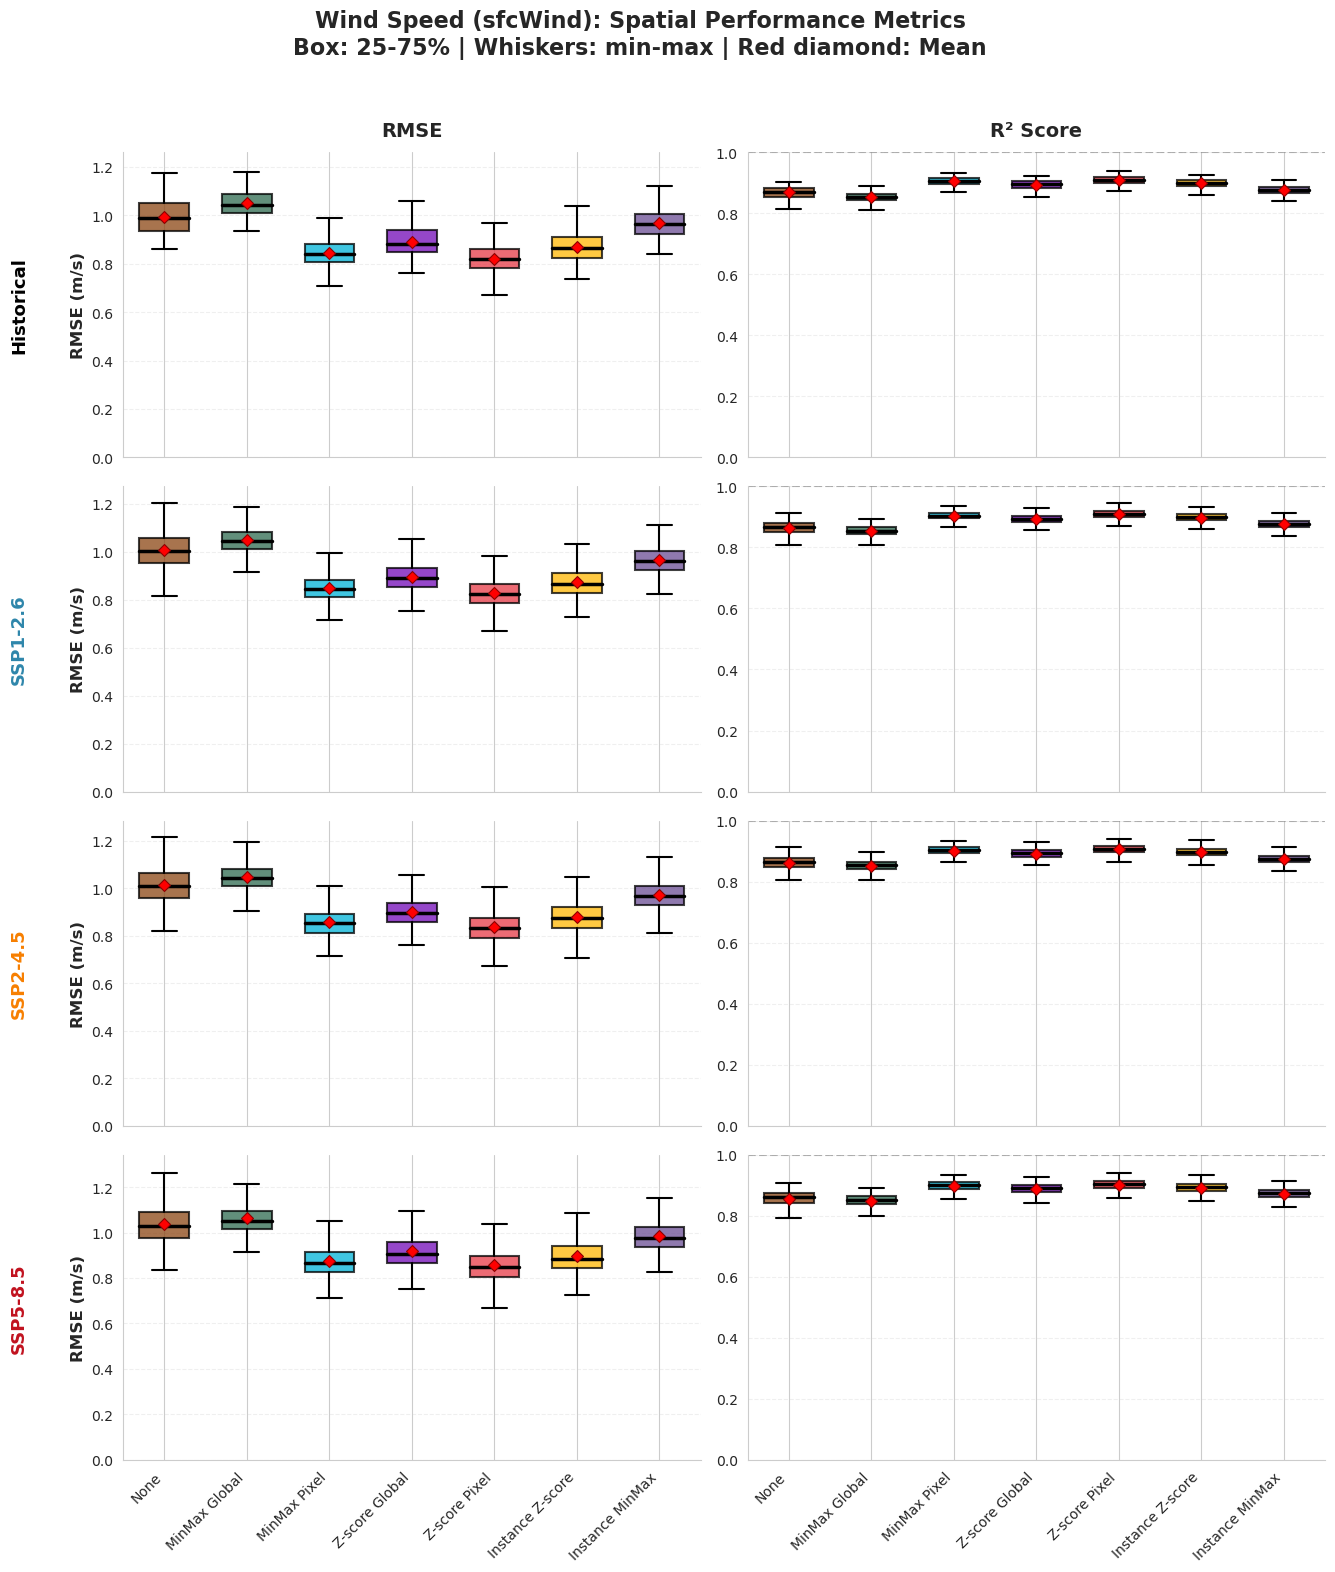

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"sfcWind_evaluation_{scenario}.nc")
    all_data[scenario] = ds

def collect_spatial_metrics_timeseries(predictions, groundtruth):
    """
    Calculate spatial metrics for each time point.
    Returns arrays of metrics for each time step.
    """
    n_time = predictions.shape[0]
    rmse_values = []
    r2_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # RMSE
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
        
        # R²
        if np.std(gt_2d) > 0:
            r2 = 1 - (np.sum((pred_2d - gt_2d)**2) / np.sum((gt_2d - np.mean(gt_2d))**2))
        else:
            r2 = np.nan
        r2_values.append(r2)
    
    return np.array(rmse_values), np.array(r2_values)

# All normalization methods
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'none': 'None',
    'minmax_global': 'MinMax Global',
    'minmax_pixel': 'MinMax Pixel',
    'zscore_global': 'Z-score Global',
    'zscore_pixel': 'Z-score Pixel',
    'instance_zscore': 'Instance Z-score',
    'instance_minmax': 'Instance MinMax'
}

# Colors for each model
model_colors = {
    'none': '#8B4513',
    'minmax_global': '#2D6A4F',
    'minmax_pixel': '#00B4D8',
    'zscore_global': '#7209B7',
    'zscore_pixel': '#E63946',
    'instance_zscore': '#FFB703',
    'instance_minmax': '#6A4C93'
}

# Scenario colors
scenario_colors = {
    'historical': '#000000',
    'ssp126': '#2E86AB',
    'ssp245': '#F77F00',
    'ssp585': '#C1121F'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Collect all metrics for box plots
metrics_data = {}

for scenario in scenarios:
    ds = all_data[scenario]
    metrics_data[scenario] = {}
    
    # Get ground truth
    gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
    
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values  # Shape: (time, lat, lon)
            
            # Calculate metrics for each time step
            rmse_ts, r2_ts = collect_spatial_metrics_timeseries(pred_data, gt_data)
            
            metrics_data[scenario][norm_method] = {
                'rmse': rmse_ts,
                'r2': r2_ts
            }

# Create 4x2 box plot figure (4 scenarios × 2 metrics)
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

metric_info = [
    {'key': 'rmse', 'label': 'RMSE (m/s)', 'ylim': None, 'ref_line': None},
    {'key': 'r2', 'label': 'R² Score', 'ylim': (0.0, 1.0), 'ref_line': 1.0}
]

# Create box plots
for row, scenario in enumerate(scenarios):
    for col, metric in enumerate(metric_info):
        ax = axes[row, col]
        
        # Prepare data for box plot
        box_data = []
        positions = []
        colors = []
        
        for i, norm in enumerate(norm_methods):
            if norm in metrics_data[scenario]:
                data = metrics_data[scenario][norm][metric['key']]
                # Remove NaN values for R²
                if metric['key'] == 'r2':
                    data = data[~np.isnan(data)]
                box_data.append(data)
                positions.append(i + 1)
                colors.append(model_colors[norm])
        
        # Create box plot
        bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=2.5),
                        boxprops=dict(linewidth=1.5),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.75)
        
        # Formatting
        ax.set_xticks(positions)
        
        # Only show x-axis labels on bottom row
        if row == 3:
            ax.set_xticklabels([model_labels[norm] for norm in norm_methods], 
                              rotation=45, ha='right', fontsize=10)
        else:
            ax.set_xticklabels([])
        
        # Set y-axis limits
        if metric['ylim'] is not None:
            ax.set_ylim(metric['ylim'])
        else:
            # Auto-scale for RMSE
            if len(box_data) > 0:
                all_data = np.concatenate(box_data)
                ax.set_ylim(0, np.percentile(all_data, 99) * 1.1)
        
        # Y-axis labels only on leftmost column (column 0)
        if col == 0:
            ax.set_ylabel(metric['label'], fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # Titles on top row showing metric type
        if row == 0:
            ax.set_title(metric['label'].split('(')[0].strip(), 
                        fontsize=14, fontweight='bold', pad=12)
        
        # Add scenario label on leftmost column
        if col == 0:
            ax.text(-0.18, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=13, fontweight='bold',
                   rotation=90, va='center', ha='center',
                   color=scenario_colors[scenario])
        
        # Grid
        ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Add mean marker (red diamond)
        for i, data_values in enumerate(box_data):
            mean_val = np.mean(data_values)
            ax.plot(positions[i], mean_val, 'D', color='red', 
                   markersize=6, zorder=10, markeredgecolor='darkred', markeredgewidth=0.8)
        
        # Add reference line for R²
        if metric['ref_line'] is not None:
            ax.axhline(y=metric['ref_line'], color='gray', linestyle='--', 
                      linewidth=1.5, alpha=0.6)
        
        ax.tick_params(labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Main title
fig.suptitle('Wind Speed (sfcWind): Spatial Performance Metrics\n' + 
             'Box: 25-75% | Whiskers: min-max | Red diamond: Mean',
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Save
# plt.savefig('spatial_metrics_boxplot_sfcWind.png', dpi=300, bbox_inches='tight')
# plt.savefig('spatial_metrics_boxplot_sfcWind.pdf', bbox_inches='tight')

plt.show()

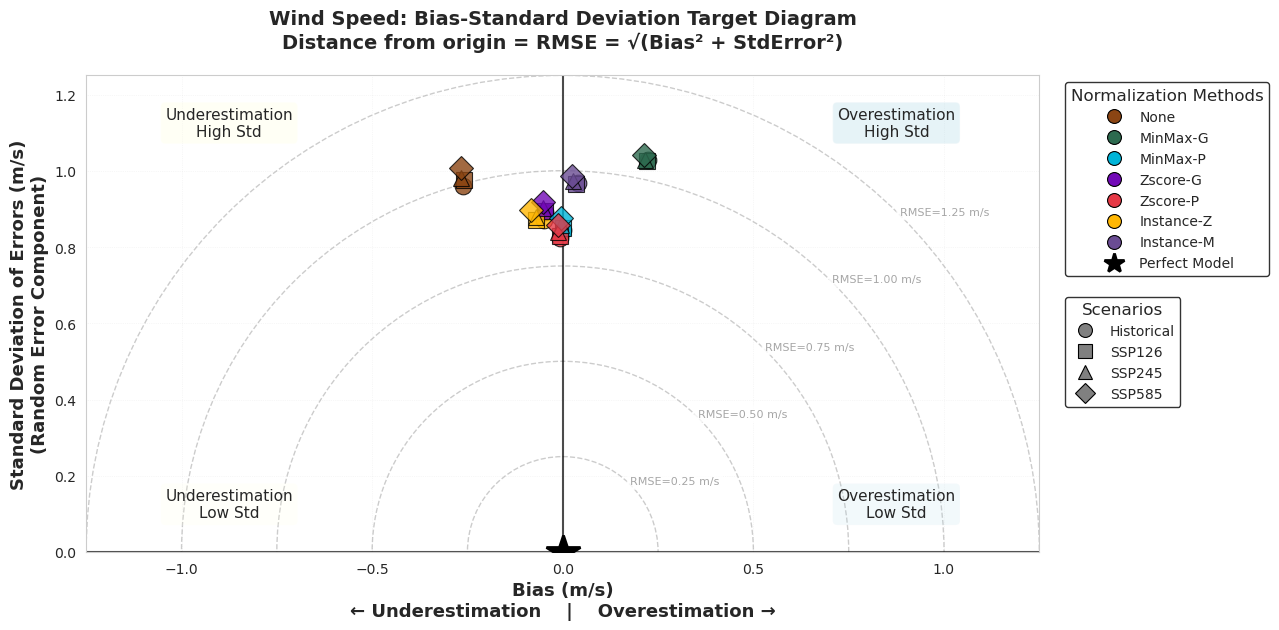

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.patches import Circle

# Set style
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"sfcWind_evaluation_{scenario}.nc")
    all_data[scenario] = ds

# Normalization methods
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'none': 'None',
    'minmax_global': 'MinMax-G',
    'minmax_pixel': 'MinMax-P',
    'zscore_global': 'Zscore-G',
    'zscore_pixel': 'Zscore-P',
    'instance_zscore': 'Instance-Z',
    'instance_minmax': 'Instance-M'
}

# Colors for each normalization method
model_colors = {
    'none': '#8B4513',
    'minmax_global': '#2D6A4F',
    'minmax_pixel': '#00B4D8',
    'zscore_global': '#7209B7',
    'zscore_pixel': '#E63946',
    'instance_zscore': '#FFB703',
    'instance_minmax': '#6A4C93'
}

# Marker styles for each scenario
scenario_markers = {
    'historical': 'o',  # circle
    'ssp126': 's',      # square
    'ssp245': '^',      # triangle up
    'ssp585': 'D'       # diamond
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585'
}

def calculate_bias_std_stats(pred_data, gt_data):
    """
    Calculate bias and standard deviation for target diagram.
    
    Returns:
    - bias: mean bias (prediction - ground truth) in m/s
    - std_error: standard deviation of errors in m/s (random error component)
    - rmse: total RMSE in m/s
    - mae: mean absolute error in m/s
    
    Note: RMSE² = Bias² + StdError²
    """
    # Flatten all data
    pred_flat = pred_data.flatten()
    gt_flat = gt_data.flatten()
    
    # Remove NaN values
    mask = ~(np.isnan(pred_flat) | np.isnan(gt_flat))
    pred_flat = pred_flat[mask]
    gt_flat = gt_flat[mask]
    
    # Calculate errors
    errors = pred_flat - gt_flat
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error component)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    # MAE
    mae = np.mean(np.abs(errors))
    
    # Verify: RMSE² = Bias² + StdError²
    rmse_check = np.sqrt(bias**2 + std_error**2)
    assert np.isclose(rmse, rmse_check, rtol=1e-5), f"RMSE decomposition failed: {rmse} vs {rmse_check}"
    
    return bias, std_error, rmse, mae

# Collect statistics for all scenarios and methods
bias_std_stats = {}

for scenario in scenarios:
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    
    bias_std_stats[scenario] = {}
    
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            
            bias, std_error, rmse, mae = calculate_bias_std_stats(pred_data, gt_data)
            
            bias_std_stats[scenario][norm_method] = {
                'bias': bias,
                'std_error': std_error,
                'rmse': rmse,
                'mae': mae
            }

# Create Target Diagram (Bias-StdError plot)
fig, ax = plt.subplots(figsize=(12, 12))

# Find max values for axis limits
max_bias = 0
max_std = 0
max_rmse = 0

for scenario in scenarios:
    for norm_method in norm_methods:
        if norm_method in bias_std_stats[scenario]:
            stats = bias_std_stats[scenario][norm_method]
            max_bias = max(max_bias, abs(stats['bias']))
            max_std = max(max_std, stats['std_error'])
            max_rmse = max(max_rmse, stats['rmse'])

# Add padding
axis_limit = max(max_bias, max_std) * 1.2

# Draw RMSE circles (distance from origin)
rmse_levels = np.linspace(0, axis_limit, 6)[1:]  # Skip 0
for rmse_level in rmse_levels:
    circle = Circle((0, 0), rmse_level, fill=False, 
                   edgecolor='gray', linestyle='--', 
                   linewidth=1, alpha=0.4, zorder=1)
    ax.add_patch(circle)
    # Label
    ax.text(rmse_level * 0.707, rmse_level * 0.707, 
           f'RMSE={rmse_level:.2f} m/s', 
           fontsize=8, color='gray', alpha=0.7,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='none', alpha=0.8))

# Draw axes
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.7, zorder=2)
ax.axvline(x=0, color='black', linewidth=1.5, alpha=0.7, zorder=2)

# Draw grid
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, zorder=1)

# Plot reference point (perfect model at origin)
ax.plot(0, 0, 'k*', markersize=25, label='Perfect Model', 
       markeredgecolor='black', markeredgewidth=2, zorder=100)

# Plot all model points
for scenario in scenarios:
    for norm_method in norm_methods:
        if norm_method in bias_std_stats[scenario]:
            stats = bias_std_stats[scenario][norm_method]
            
            bias = stats['bias']
            std_error = stats['std_error']
            
            ax.plot(bias, std_error,
                   marker=scenario_markers[scenario],
                   color=model_colors[norm_method],
                   markersize=12,
                   markeredgecolor='black',
                   markeredgewidth=0.8,
                   alpha=0.8,
                   linestyle='none',
                   zorder=50)

# Set equal aspect ratio and limits
ax.set_xlim(-axis_limit, axis_limit)
ax.set_ylim(0, axis_limit)  # Only positive std
ax.set_aspect('equal', adjustable='box')

# Labels
ax.set_xlabel('Bias (m/s)\n← Underestimation    |    Overestimation →', 
             fontsize=13, fontweight='bold')
ax.set_ylabel('Standard Deviation of Errors (m/s)\n(Random Error Component)', 
             fontsize=13, fontweight='bold')

# Add quadrant labels
ax.text(-axis_limit * 0.7, axis_limit * 0.9, 
       'Underestimation\nHigh Std', 
       fontsize=11, ha='center', va='center', 
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
ax.text(axis_limit * 0.7, axis_limit * 0.9, 
       'Overestimation\nHigh Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
ax.text(-axis_limit * 0.7, axis_limit * 0.1, 
       'Underestimation\nLow Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.15))
ax.text(axis_limit * 0.7, axis_limit * 0.1, 
       'Overestimation\nLow Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.15))

# Create custom legends
# Legend 1: Normalization methods (colors)
method_handles = []
for norm_method in norm_methods:
    handle = mlines.Line2D([], [], color=model_colors[norm_method], 
                          marker='o', linestyle='None',
                          markersize=10, label=model_labels[norm_method],
                          markeredgecolor='black', markeredgewidth=0.8)
    method_handles.append(handle)

# Legend 2: Scenarios (markers)
scenario_handles = []
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='gray', 
                          marker=scenario_markers[scenario], 
                          linestyle='None',
                          markersize=10, label=scenario_labels[scenario],
                          markeredgecolor='black', markeredgewidth=0.8)
    scenario_handles.append(handle)

# Add reference point to method legend
ref_handle = mlines.Line2D([], [], color='black', marker='*', 
                          linestyle='None', markersize=15, 
                          label='Perfect Model',
                          markeredgecolor='black', markeredgewidth=2)

# Position legends
legend1 = ax.legend(handles=method_handles + [ref_handle], 
                   loc='upper left', bbox_to_anchor=(1.02, 1.0),
                   fontsize=10, title='Normalization Methods',
                   title_fontsize=12, frameon=True, fancybox=True,
                   edgecolor='black')
legend2 = ax.legend(handles=scenario_handles, 
                   loc='upper left', bbox_to_anchor=(1.02, 0.55),
                   fontsize=10, title='Scenarios',
                   title_fontsize=12, frameon=True, fancybox=True,
                   edgecolor='black')
ax.add_artist(legend1)  # Add back the first legend

# Title
plt.title('Wind Speed: Bias-Standard Deviation Target Diagram\n' + 
         'Distance from origin = RMSE = √(Bias² + StdError²)',
         fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# Save
# plt.savefig('bias_std_target_diagram_sfcWind.png', dpi=300, bbox_inches='tight')
# plt.savefig('bias_std_target_diagram_sfcWind.pdf', bbox_inches='tight')

plt.show()

/tmp/ipykernel_133134/1476735644.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


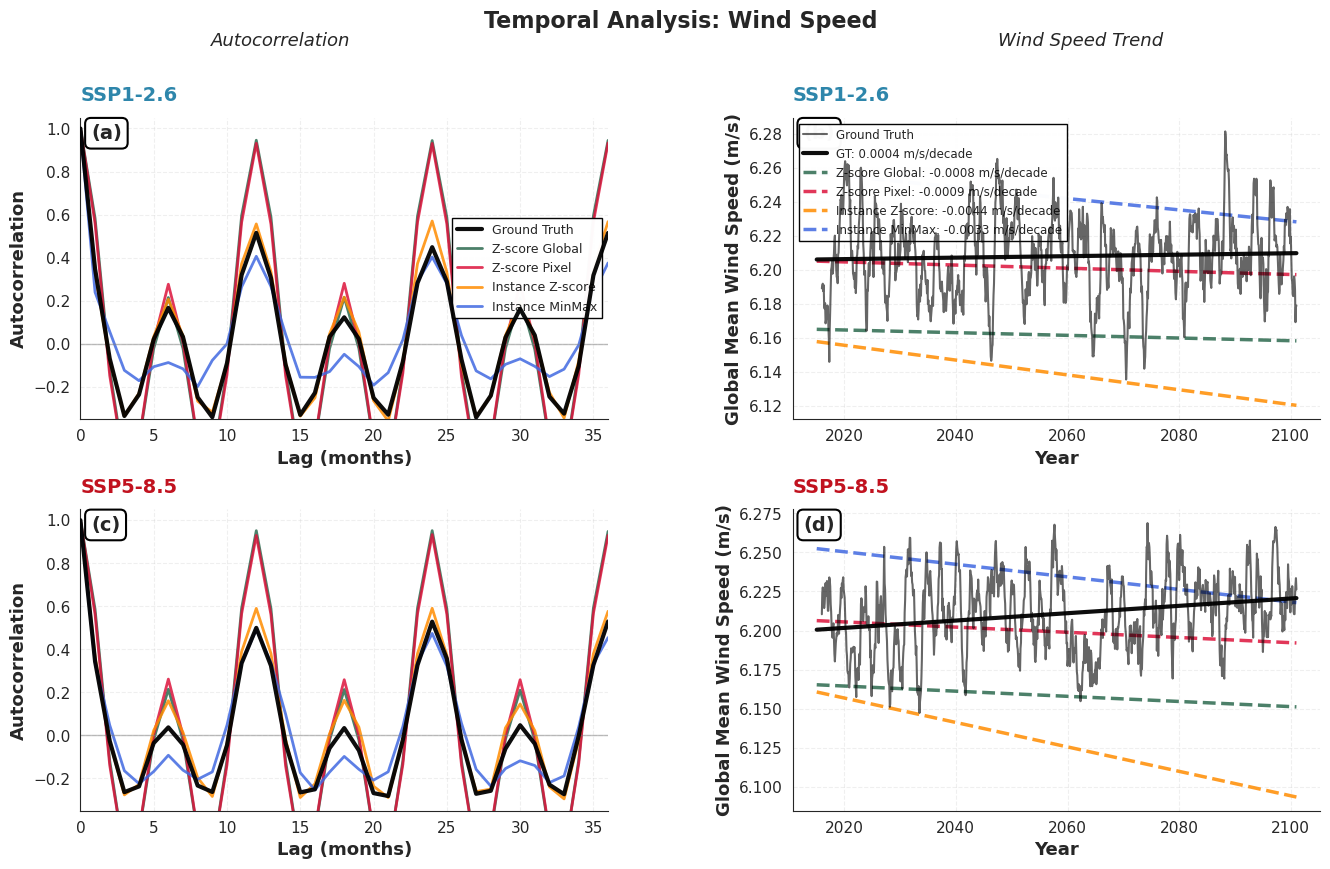

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("white")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['ssp126', 'ssp585']  # Only these two scenarios

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"sfcWind_evaluation_{scenario}.nc")
    all_data[scenario] = ds

# Selected normalization methods only
norm_methods = ['zscore_global', 'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'zscore_global': 'Z-score Global',
    'zscore_pixel': 'Z-score Pixel',
    'instance_zscore': 'Instance Z-score',
    'instance_minmax': 'Instance MinMax'
}

# Colors for each model - changed purple to green for better distinction
model_colors = {
    'zscore_global': '#2D6A4F',      # Forest Green
    'zscore_pixel': '#DC143C',       # Crimson
    'instance_zscore': '#FF8C00',    # Dark Orange
    'instance_minmax': '#4169E1'     # Royal Blue
}

# Scenario labels
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp585': 'SSP5-8.5'
}

# Scenario colors
scenario_colors = {
    'ssp126': '#2E86AB',
    'ssp585': '#C1121F'
}

def calc_global_mean(data):
    """Calculate global mean time series"""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon']).values
    else:
        return np.mean(data, axis=(1, 2))

def calculate_autocorrelation(time_series, max_lag=36):
    """
    Calculate temporal autocorrelation function.
    
    Parameters:
    - time_series: 1D array of values over time
    - max_lag: maximum lag to calculate (in time steps)
    
    Returns:
    - lags: array of lag values
    - acf: autocorrelation values
    """
    n = len(time_series)
    mean = np.mean(time_series)
    var = np.var(time_series)
    
    acf = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        if lag == 0:
            acf[lag] = 1.0
        else:
            c0 = np.sum((time_series[:n-lag] - mean) * (time_series[lag:] - mean))
            acf[lag] = c0 / (var * (n - lag))
    
    lags = np.arange(max_lag + 1)
    return lags, acf

def calculate_trend(time_series, time_coords):
    """
    Calculate linear trend using least squares regression.
    
    Parameters:
    - time_series: 1D array of values over time
    - time_coords: time coordinates (e.g., years)
    
    Returns:
    - slope: trend in units per time unit (e.g., m/s/year)
    - intercept: intercept of trend line
    - r_value: correlation coefficient
    - p_value: p-value for hypothesis test
    """
    # Remove NaN values
    mask = ~np.isnan(time_series)
    x = time_coords[mask]
    y = time_series[mask]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value

# Create figure: 2 rows (scenarios) x 2 columns (autocorrelation + trend)
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.35)

# Store trend statistics for summary table
trend_stats = {}

for row_idx, scenario in enumerate(scenarios):
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    time = ds.time
    
    # Convert time to decimal years for trend analysis
    years = time.dt.year.values + time.dt.month.values / 12.0
    
    # Get ground truth global mean time series
    gt_mean = calc_global_mean(gt_data)
    
    # Calculate ground truth autocorrelation
    lags, gt_acf = calculate_autocorrelation(gt_mean, max_lag=36)
    
    # Calculate ground truth trend
    gt_slope, gt_intercept, gt_r, gt_p = calculate_trend(gt_mean, years)
    
    trend_stats[scenario] = {'Ground Truth': {
        'slope': gt_slope,
        'r_value': gt_r,
        'p_value': gt_p
    }}
    
    # Left column: Autocorrelation
    ax_acf = fig.add_subplot(gs[row_idx, 0])
    
    # Plot ground truth ACF with thick line
    ax_acf.plot(lags, gt_acf, color='black', linewidth=3, 
               label='Ground Truth', alpha=0.95, zorder=20)
    
    # Plot predictions ACF
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate autocorrelation
            _, pred_acf = calculate_autocorrelation(pred_mean, max_lag=36)
            
            ax_acf.plot(lags, pred_acf, 
                       color=model_colors[norm_method],
                       linewidth=2, alpha=0.85,
                       label=model_labels[norm_method])
    
    # Format ACF plot
    ax_acf.set_xlabel('Lag (months)', fontsize=13, fontweight='bold')
    ax_acf.set_ylabel('Autocorrelation', fontsize=13, fontweight='bold')
    ax_acf.set_title(f'{scenario_labels[scenario]}', 
                    fontsize=14, fontweight='bold', color=scenario_colors[scenario], 
                    pad=12, loc='left')
    ax_acf.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax_acf.set_ylim(-0.35, 1.05)
    ax_acf.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax_acf.set_xlim(0, 36)
    
    # Add legend - moved to right side
    if row_idx == 0:
        ax_acf.legend(loc='center right', fontsize=9, framealpha=0.98, 
                     edgecolor='black', fancybox=False, bbox_to_anchor=(1.0, 0.5))
    
    ax_acf.tick_params(labelsize=11)
    ax_acf.spines['top'].set_visible(False)
    ax_acf.spines['right'].set_visible(False)
    
    # Right column: Trend Analysis
    ax_trend = fig.add_subplot(gs[row_idx, 1])
    
    # Calculate 12-month rolling mean for smoother visualization
    window = 12
    if len(gt_mean) >= window:
        gt_mean_smooth = np.convolve(gt_mean, np.ones(window)/window, mode='valid')
        years_smooth = years[window-1:]
    else:
        gt_mean_smooth = gt_mean
        years_smooth = years
    
    # Plot ground truth as LINE instead of scatter
    ax_trend.plot(years_smooth, gt_mean_smooth, color='black', linewidth=1.5, 
                 alpha=0.6, label='Ground Truth', zorder=18)
    
    # Plot ground truth trend line
    gt_trend_line = gt_slope * years + gt_intercept
    ax_trend.plot(years, gt_trend_line, 'k-', linewidth=3, alpha=0.95,
                 label=f'GT: {gt_slope*10:.4f} m/s/decade', zorder=19)
    
    # Plot predictions with trend lines
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate trend
            pred_slope, pred_intercept, pred_r, pred_p = calculate_trend(pred_mean, years)
            
            # Store trend stats
            trend_stats[scenario][norm_method] = {
                'slope': pred_slope,
                'r_value': pred_r,
                'p_value': pred_p
            }
            
            # Plot trend line only (no data points)
            pred_trend_line = pred_slope * years + pred_intercept
            ax_trend.plot(years, pred_trend_line, 
                         color=model_colors[norm_method],
                         linewidth=2.5, alpha=0.85,
                         linestyle='--',
                         label=f'{model_labels[norm_method]}: {pred_slope*10:.4f} m/s/decade')
    
    # Format trend plot
    ax_trend.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax_trend.set_ylabel('Global Mean Wind Speed (m/s)', fontsize=13, fontweight='bold')
    ax_trend.set_title(f'{scenario_labels[scenario]}', 
                      fontsize=14, fontweight='bold', color=scenario_colors[scenario], 
                      pad=12, loc='left')
    ax_trend.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Add legend - moved outside to the right
    if row_idx == 0:
        ax_trend.legend(loc='upper left', fontsize=8.5, framealpha=0.98,
                       edgecolor='black', fancybox=False, bbox_to_anchor=(0.0, 1.0))
    
    ax_trend.tick_params(labelsize=11)
    ax_trend.spines['top'].set_visible(False)
    ax_trend.spines['right'].set_visible(False)

# Add panel labels
axes = fig.get_axes()
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axes, panel_labels):
    ax.text(0.02, 0.98, label, transform=ax.transAxes,
           fontsize=14, fontweight='bold', va='top', ha='left',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='black', linewidth=1.5))

# Overall title
fig.text(0.5, 0.98, 'Temporal Analysis: Wind Speed', 
        ha='center', fontsize=16, fontweight='bold')
fig.text(0.25, 0.96, 'Autocorrelation', 
        ha='center', fontsize=13, style='italic')
fig.text(0.75, 0.96, 'Wind Speed Trend', 
        ha='center', fontsize=13, style='italic')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save
# plt.savefig('temporal_analysis_sfcWind.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig('temporal_analysis_sfcWind.pdf', bbox_inches='tight', facecolor='white')

plt.show()